<a href="https://colab.research.google.com/github/tsjannoun123-netizen/AI-for-Med.Diagnos.-Prediction-AAI_643O_O11_202610/blob/main/Week3_lesson1_Saera_Rawas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for practical exercises | Week #3 Lesson #1

## Introduction

This notebook contains practical hands-on exercises for the lesson about *Supervised Learning in Medicine*.

After this session, you will know how to create, train and validate a classifier for a real-world clinical problem:
* Create the classifier object ;
* Understand the impact of hyperparameters ;
* Compare different classification algorithms.

## Dataset

As last week, we will use the [The Brain Resection Multimodal Imaging Database](https://www.cancerimagingarchive.net/collection/remind/) [1]. The Brain Resection Multimodal Imaging Database (ReMIND) contains pre- and intra-operative brain MRI collected on 114 consecutive patients who were surgically treated with image-guided tumor resection between 2018 and 2022.

[1] Juvekar, P., Dorent, R., Kögl, F., Torio, E., Barr, C., Rigolo, L., Galvin, C., Jowkar, N., Kazi, A., Haouchine, N., Cheema, H., Navab, N., Pieper, S., Wells, W. M., Bi, W. L., Golby, A., Frisken, S., & Kapur, T. (2023). The Brain Resection Multimodal Imaging Database (ReMIND) (Version 1) [dataset]. The Cancer Imaging Archive. [https://doi.org/10.7937/3RAG-D070](https://doi.org/10.7937/3RAG-D070)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Download

If needed, run the following cells to download and unzip the radiomics and metadata csv files.

<div class="alert alert-block alert-danger">
<b>Replace the <code>DATA_PATH</code> with the path where you want to store the data folder. By default, it will be stored at the root of this repository.</b> <br>
<b>If you have already downloaded the dataset, comment the following cell by adding a <code>#</code> before the <code>!</code></b>
</div>

In [3]:
DATA_PATH = './'

if not os.path.exists(f'{DATA_PATH}/data'):
    os.mkdir(f'{DATA_PATH}/data')

if not os.path.exists(f'{DATA_PATH}/data/ReMIND'):
    os.mkdir(f'{DATA_PATH}/data/ReMIND')

!curl https://uni-bonn.sciebo.de/s/eIHqHLT6dvsaSck/download --output {DATA_PATH}/data/ReMIND/radiomics_standardized.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  183k  100  183k    0     0   161k      0  0:00:01  0:00:01 --:--:--  161k


### Quick reminder

Last week, we learned how to clean, organize and extract features from a brain MRI dataset with segmentation masks of tumors. Our objective is now to train a classifier to identify the tumor grade from the radiomic features.

In [4]:
radiomics_df = pd.read_csv(f'{DATA_PATH}/data/ReMIND/radiomics_standardized.csv')
radiomics_df.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,patient,tumor
0,0.860020,1.122862,1.396610,0.253136,0.830442,0.343751,0.356849,0.251977,0.471729,0.715953,...,0.587638,-0.229040,-0.301505,-0.181221,-0.331200,-0.111814,-0.408733,-0.158659,1,3
1,1.025073,0.507871,0.104606,-0.356884,-0.209951,-0.226259,-0.214213,-0.377701,-0.208317,0.018649,...,-0.176907,-0.812217,-0.202383,-0.030719,-0.284125,-0.123831,-0.506981,-0.294942,2,2
2,-0.954156,-0.646563,-1.035618,-0.921583,-0.792979,-0.973916,-1.203671,-0.885273,-0.487601,-1.091582,...,0.508167,-0.219850,-0.376836,-0.430580,-0.202489,-0.115482,-0.482961,0.650141,3,2
3,1.339663,1.151933,-0.819872,-1.215635,-1.077766,-1.223924,-1.169485,-1.223477,-0.488464,-1.026820,...,-1.079740,-0.226175,-0.378617,-0.318686,0.135175,-0.124402,-0.314173,-0.201749,4,1
4,-0.509357,-0.613268,-0.660474,-0.472525,-0.303654,-0.289065,-0.707875,-0.314526,-0.424301,-0.585267,...,1.411481,0.678000,-0.384729,-0.423384,-0.291855,-0.070733,-0.298664,1.349813,6,2


## Dataset split

In machine learning, we usually split the datasets into three components:
* A `train` set, that will be used to fit the model (usually 70% of the data);
* A `valid` set, that will be used to optimize the model (usually 10% of the data);
* And a `test` set, that will be used to evaluate performance (usually 20% of the data).

In healthcare, it is important that this splitting is performed at the **patient level** to avoid any data leakage. Indeed, if a model has been trained on data from patient X at time point t, it is more than likely that the model will remember the information when classifying data from the same patient at time point t+1 (or from a different modality). Thus, we might **overestimate the performance** of our classifier.

To do the splitting, we need to run the following steps:
1. Get the list of patient ID, and remove duplicates to avoid selecting the same patient in different splits ;
2. Split the patient list into train and test sets ;
3. Split the train sets into train and valid sets.

In [5]:
patient_list = radiomics_df['patient'].unique()

Now, we will use the `train_test_split` function from scikit-learn to divide the patient list into two non-overlapping sets.

In [6]:
from sklearn.model_selection import train_test_split

patient_train, patient_test = train_test_split(
    patient_list, # List or array to split
    test_size=0.2, # Size of the subset
    random_state=42)

<div class="alert alert-block alert-info">
<b>Q1.</b> Use the same function to split the <code>train</code> and <code>valid</code> sets. The <code>valid</code> set should contain 10% of the <code>train</code> set.
</div>

In [7]:
patient_train, patient_val = train_test_split(
    patient_train,
    test_size=0.1 / 0.8,
    random_state=42)

<div class="alert alert-block alert-info">
<b>Q2.</b> Observe the list of patients in each set and their tumor attribute. How is the label repartition across sets?
</div>

In [8]:
radiomics_df['tumor'].loc[radiomics_df['patient'].isin(patient_train)].value_counts()

,count
tumor,
4,26
3,17
2,13
1,3


In [9]:
radiomics_df['tumor'].loc[radiomics_df['patient'].isin(patient_val)].value_counts()

,count
tumor,
2,4
4,3
3,2


In [10]:
radiomics_df['tumor'].loc[radiomics_df['patient'].isin(patient_test)].value_counts()

,count
tumor,
2,9
4,7
3,2


The dataset is imbalanced with much more tumors of grade 4 than tumors of grade 2 or 3, and very few grade 1.

We can lessen the effect of this imbalance  by stratifying the splitting to balance the repartition of labels across sets to have similar proportions of labels across sets.

In [11]:
patient_train, patient_test = train_test_split(
    patient_list, # List or array to split
    test_size=0.2, # Size of the subset
    stratify= radiomics_df['tumor'].loc[radiomics_df['patient'].isin(patient_list)],
    random_state=42)

In [12]:
patient_train, patient_val = train_test_split(
    patient_train,
    test_size=0.1 / 0.8,
    stratify= radiomics_df['tumor'].loc[radiomics_df['patient'].isin(patient_train)],
    random_state=42)

<div class="alert alert-block alert-info">
<b>Q3.</b> Compare the actual label repartition with the previous one. Do we have more balanced sets?
</div>

In [13]:
radiomics_df['tumor'].loc[radiomics_df['patient'].isin(patient_train)].value_counts()

,count
tumor,
4,24
2,18
3,15
1,2


In [14]:
radiomics_df['tumor'].loc[radiomics_df['patient'].isin(patient_val)].value_counts()

,count
tumor,
4,4
2,3
3,2


In [15]:
radiomics_df['tumor'].loc[radiomics_df['patient'].isin(patient_test)].value_counts()

,count
tumor,
4,8
2,5
3,4
1,1


The actual distributions are still imbalanced, with one class (usually 4 or 2) having the most samples and class 1 being the rarest.

The imbalance is slightly reduced class 4 from 44.1% to 40.7%, but not significantly.

The sets remain unbalanced, with no major improvement in balance. The relative proportions are similar, and the minority classes (especially tumor 1) are still underrepresented.

## Naïve Bayes Classifier

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Bayes’ theorem states the following relationship, given class variable $y$ and dependent feature vector $x_1$ through $x_n$: $P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots, x_n \mid y)}
                                    {P(x_1, \dots, x_n)}$

Using the naive conditional independence assumption that $P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y)$

for all $i$, this relationship is simplified to $P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)}
                                    {P(x_1, \dots, x_n)}$

Since $P(x_1, \dots, x_n)$ is constant given the input, we can use the following classification rule:
$P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)$ $\rightarrow$ $\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y)$

and we can use Maximum A Posteriori (MAP) estimation to estimate $P(y)$ and $P(x_i \mid y)$; the former is then the relative frequency of class y in the training set.

The different naive Bayes classifiers differ mainly by the assumptions they make regarding the distribution of $P(x_i \mid y)$.


We will compare the performance of different Naïve Bayes Classifiers on the `valid` set.

In [16]:
X_train = radiomics_df.loc[radiomics_df['patient'].isin(patient_train)]
y_train = radiomics_df.loc[radiomics_df['patient'].isin(patient_train)]['tumor']

X_val = radiomics_df.loc[radiomics_df['patient'].isin(patient_val)]
y_val = radiomics_df.loc[radiomics_df['patient'].isin(patient_val)]['tumor']

In [17]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

preds = gnb.predict(X_val)

In [18]:
print('True labels:', y_val.tolist())
print('Predictions:', preds.tolist())

True labels: [3, 3, 4, 4, 4, 2, 2, 4, 2]
Predictions: [3, 3, 4, 4, 4, 2, 2, 4, 2]


<div class="alert alert-block alert-info">
<b>Q4.</b> Compare these predictions with the ones obtained from a <code>Bernouilli Naïve Bayes</code> algorithm.
</div>

In [19]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train, y_train)

preds_bnb = bnb.predict(X_val)

print('True labels:', y_val.tolist())
print('Predictions:', preds_bnb.tolist())

True labels: [3, 3, 4, 4, 4, 2, 2, 4, 2]
Predictions: [4, 1, 4, 4, 4, 4, 3, 4, 3]


Model A (first predictions) achieves perfect accuracy (100%). This is likely a baseline or a very good model.

Model B (Bernoulli Naïve Bayes) has low accuracy (44.4%). It misclassifies all samples of class 2 and 3, and has one false positive for class 1.

The first model (A) is superior with 100% accuracy.

The Bernoulli Naïve Bayes model (B) performs poorly (44.4% accuracy) and is not suitable for this data without feature transformation (e.g., binarization) or addressing class imbalance.

## k-Nearest Neighbors

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (`k-nearest neighbor learning`), or vary based on the local density of points (`radius-based neighbor learning`). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice.



In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

preds_knn = knn.predict(X_val)

print('True labels:', y_val.tolist())
print('Predictions:', preds_knn.tolist())

True labels: [3, 3, 4, 4, 4, 2, 2, 4, 2]
Predictions: [2, 2, 2, 3, 2, 3, 3, 4, 3]


<div class="alert alert-block alert-info">
<b>Q5.</b> Vary the number of neighbors and compare the predictions. What is the optimal number of neighbors for this dataset?
</div>

In [21]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

preds_knn = knn.predict(X_val)

print('True labels:', y_val.tolist())
print('Predictions:', preds_knn.tolist())

True labels: [3, 3, 4, 4, 4, 2, 2, 4, 2]
Predictions: [2, 2, 2, 3, 2, 3, 2, 4, 3]


In [22]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)

preds_knn = knn.predict(X_val)

print('True labels:', y_val.tolist())
print('Predictions:', preds_knn.tolist())

True labels: [3, 3, 4, 4, 4, 2, 2, 4, 2]
Predictions: [2, 2, 2, 4, 2, 4, 4, 4, 3]


In [23]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train, y_train)

preds_knn = knn.predict(X_val)

print('True labels:', y_val.tolist())
print('Predictions:', preds_knn.tolist())

True labels: [3, 3, 4, 4, 4, 2, 2, 4, 2]
Predictions: [2, 2, 2, 4, 4, 4, 4, 4, 3]


Summary of Accuracies:
k=5: 11.1%
k=3: 22.2%
k=7: 22.2%
k=9: 33.3%
The highest accuracy is achieved with k=9
(33.3%). However, note that all accuracies are low, indicating that k-NN may not be well-suited for this dataset without feature scaling or other preprocessing. But among the given choices,
k=9 is the best.



## Logistic Regression

In [24]:
# Import logistic regression library
from sklearn.linear_model import LogisticRegression

# Create the logistic regression model object
logistic = LogisticRegression()

# Train the model
logistic.fit(X_train, y_train)

# Check the predictions on the train set
preds_log = logistic.predict(X_train)

print('True labels:', y_train.tolist())
print('Predictions:', preds_log.tolist())

print('Score:', logistic.score(X_train, y_train))

True labels: [2, 2, 1, 2, 2, 3, 4, 1, 2, 2, 4, 3, 3, 3, 3, 4, 4, 2, 3, 2, 4, 4, 4, 3, 4, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 3, 4, 4, 3, 4, 2, 4, 4, 4, 4, 4, 2, 3, 2, 4, 3, 2, 3, 2, 3, 4, 4, 4]
Predictions: [2, 2, 1, 2, 2, 3, 4, 1, 2, 2, 4, 3, 3, 3, 3, 4, 4, 2, 3, 2, 4, 4, 4, 3, 4, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 3, 4, 4, 3, 4, 2, 4, 4, 4, 4, 4, 2, 3, 2, 4, 3, 2, 3, 2, 3, 4, 4, 4]
Score: 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
preds_log = logistic.predict(X_val)

print('True labels:', y_val.tolist())
print('Predictions:', preds_log.tolist())
print('Score:', logistic.score(X_val, y_val))

True labels: [3, 3, 4, 4, 4, 2, 2, 4, 2]
Predictions: [3, 4, 4, 4, 4, 3, 2, 4, 3]
Score: 0.6666666666666666


In [26]:
# Output the equation coefficient and intercept
print('Logistic Model Coefficient: ', logistic.coef_)
print('Logistic Model Intercept: ', logistic.intercept_)

Logistic Model Coefficient:  [[ 1.14748581e-01  1.14290955e-01 -8.90855667e-02 -1.25419664e-01
  -1.12230335e-01 -1.28648784e-01 -1.16880268e-01 -1.27471701e-01
  -4.16350687e-02 -1.06663037e-01  1.73729521e-01 -6.30728268e-02
   1.30416919e-01 -4.16622745e-02 -4.46910883e-02 -2.85317709e-02
  -1.10689988e-02 -5.24412630e-02 -2.06560837e-02 -8.20395579e-02
  -5.27557681e-02 -2.21143630e-02 -4.02633929e-02 -3.82515772e-02
   1.06044056e-01 -6.10293765e-02 -1.98410451e-02 -3.81241743e-02
  -1.26439829e-02 -1.20677471e-02  2.33532172e-02 -1.03884759e-02
  -2.28044345e-02 -7.62177853e-03 -7.90001205e-03 -1.04367762e-02
  -1.17218999e-02 -9.17677034e-02 -1.33586092e-02 -5.07560848e-04
  -1.15572711e-02 -3.70446092e-02 -4.06149788e-02 -1.98254823e-01
  -1.92143592e-01  4.29757479e-03 -1.76555255e-01  1.23228203e-02
  -8.24721999e-02 -1.09000107e-02 -7.04969341e-02 -5.60092863e-02
  -3.05753346e-03 -8.24721999e-02 -8.10738289e-02 -1.05026077e-02
  -1.87965438e-01 -3.73302686e-02  4.93552483e-

### Regularization in Logistic Regression

Overfitting occurs when a model is too complex and fits the training data too closely, resulting in poor generalization to new data. This can be a problem for logistic regression models, as they can become overly complex if there are many features or the relationship between the features and the target is non-linear. Overfitting can lead to poor performance on the test set and low predictive power on new data.

**Regularization** is a technique used to avoid overfitting in machine learning models. It does this by adding a penalty term to the objective function (also called the loss function or error function) that the model is trying to minimize. The objective function measures the error or difference between the predicted output of the model and the true output. In logistic regression, the objective function is typically the cross-entropy loss, which measures the difference between the predicted probability of the positive class and the true label (1 or 0).

By adding a penalty term to the objective function, regularization helps to reduce the complexity of the model and prevent it from fitting the training data too closely. The penalty term is a hyperparameter that controls the strength of the regularization. A higher value for the penalty term leads to stronger regularization and a simpler model, while a lower value allows the model to be more complex.

#### Types of regularization
* **L1 (Lasso) regularization**: Adds a penalty term to the objective function equal to the absolute value of the coefficients. This leads to a sparse model, where many of the coefficients are exactly equal to zero. L1 regularization is useful for feature selection because it can automatically identify and remove unnecessary or redundant features from the model.

* **L2 (Ridge) regularization**: Adds a penalty term to the objective function equal to the square of the coefficients. This leads to a model with all coefficients close to zero, but not necessarily equal to zero. L2 regularization is less prone to overfitting than L1 regularization and is often used as a default choice.

* **Elastic Net regularization**: Combines L1 and L2 regularization by adding a penalty term to the objective function that is a combination of the absolute value and square of the coefficients. This leads to a model with some coefficients equal to zero and some close to zero. Elastic Net can be useful when there are correlated features in the data and Lasso is prone to selecting only one of them.


In [27]:
# Set the regularization type (L1, L2, Elastic Net)
penalty = 'elasticnet'

# Set the regularization strength (C)
C = 0.9

# Set the l1 ratio when using elasticnet
l1_ratio=0.5

# Create a logistic regression model
logistic = LogisticRegression(penalty=penalty, C=C, solver='saga', l1_ratio=l1_ratio)

# Train the model on the training set
logistic.fit(X_train, y_train)

print('Train:', logistic.score(X_train, y_train))
print('Valid:', logistic.score(X_val, y_val))

Train: 0.6440677966101694
Valid: 0.4444444444444444


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<div class="alert alert-block alert-info">
<b>Q6.</b> Vary the hyperparameters (penalty, strength and l1 ratio) and compare the predictions on the valid set and on the train set. Does adding the penalty terms avoid overfitting?
</div>

In [28]:
for penalty in ['l1', 'l2', 'elasticnet']:
    for C in [0.01, 0.1, 1]:
        # Create a logistic regression model
        logistic = LogisticRegression(penalty=penalty, C=C, solver='saga', l1_ratio=0.5)

        # Train the model on the training set
        logistic.fit(X_train, y_train)
        print('Regularization:', penalty, 'C:', C)
        print('Train:', logistic.score(X_train, y_train))
        print('Valid:', logistic.score(X_val, y_val))

Regularization: l1 C: 0.01
Train: 0.4406779661016949
Valid: 0.4444444444444444
Regularization: l1 C: 0.1
Train: 0.423728813559322
Valid: 0.4444444444444444
Regularization: l1 C: 1
Train: 0.6440677966101694
Valid: 0.4444444444444444


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: Convergen

Regularization: l2 C: 0.01
Train: 0.5932203389830508
Valid: 0.4444444444444444
Regularization: l2 C: 0.1
Train: 0.6610169491525424
Valid: 0.5555555555555556
Regularization: l2 C: 1
Train: 0.6610169491525424
Valid: 0.4444444444444444


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Regularization: elasticnet C: 0.01
Train: 0.4406779661016949
Valid: 0.4444444444444444
Regularization: elasticnet C: 0.1
Train: 0.5084745762711864
Valid: 0.4444444444444444
Regularization: elasticnet C: 1
Train: 0.6271186440677966
Valid: 0.4444444444444444


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Adding penalty terms (regularization) avoids overfitting by constraining the model coefficients. The best result is achieved with L2 regularization (Ridge) and C=1, which gives the highest validation accuracy (0.5556) and reduces the overfitting gap.

## Support Vector Machine

SVM is a supervised learning algorithm that finds the optimal hyperplane to separate data into classes by maximizing the margin between them. To handle imperfect data, SVM introduces a penalty term (like in logistic regression), controlled by the parameter C:
* Large C: less tolerance for misclassification.
* Small C: allows a wider margin with some misclassifications.

SVMs can also handle non-linear data using kernels, which map data into higher-dimensional space:
* Linear: for linearly separable data.
* Polynomial: maps inputs into polynomial space.
* RBF (Gaussian): handles complex, non-linear patterns.
* Sigmoid: similar to neural networks, less common.

Kernels let SVMs create flexible decision boundaries while maintaining good generalization.

<div class="alert alert-block alert-info">
<b>Q7.</b> Similarly to what we have done with logistic regression, compare the scores obtained when training SVM with different kernels and different values for C.
</div>

In [29]:
from sklearn.svm import SVC

# Kernels and regularization strengths to compare
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.01, 0.1, 1]

# Evaluate performance for each kernel and C value
for kernel in kernels:
    for C in C_values:
        svm = SVC(kernel=kernel, C=C, gamma='auto')
        svm.fit(X_train, y_train)
        print('Kernel:', kernel, 'C:', C)
        print('Train:', svm.score(X_train, y_train))
        print('Valid:', svm.score(X_val, y_val))

Kernel: linear C: 0.01
Train: 0.7288135593220338
Valid: 0.3333333333333333
Kernel: linear C: 0.1
Train: 0.9661016949152542
Valid: 0.5555555555555556
Kernel: linear C: 1
Train: 1.0
Valid: 0.6666666666666666
Kernel: poly C: 0.01
Train: 0.847457627118644
Valid: 0.4444444444444444
Kernel: poly C: 0.1
Train: 0.9491525423728814
Valid: 0.4444444444444444
Kernel: poly C: 1
Train: 0.9830508474576272
Valid: 0.4444444444444444
Kernel: rbf C: 0.01
Train: 0.4067796610169492
Valid: 0.4444444444444444
Kernel: rbf C: 0.1
Train: 0.4067796610169492
Valid: 0.4444444444444444
Kernel: rbf C: 1
Train: 0.7966101694915254
Valid: 0.2222222222222222
Kernel: sigmoid C: 0.01
Train: 0.4067796610169492
Valid: 0.4444444444444444
Kernel: sigmoid C: 0.1
Train: 0.4067796610169492
Valid: 0.4444444444444444
Kernel: sigmoid C: 1
Train: 0.4067796610169492
Valid: 0.4444444444444444


The goal is to find a model that generalizes well (high validation score) without overfitting (small gap between train and validation scores)
Best Performance:
The linear kernel with C=1 achieves the highest validation score (0.6667) among all configurations.

The next best is linear kernel with C=0.1 (valid = 0.5556).

The polynomial kernel consistently gives a validation score of 0.4444 regardless of C, which is not better than linear.

RBF and sigmoid kernels perform poorly.
For linear kernel, as C increases:

Train accuracy increases (from 0.7288 to 1.0).

Validation accuracy increases (from 0.3333 to 0.6667).

But the gap also increases (from 0.3955 to 0.3333), meaning overfitting increases slightly.

However, C=1 gives the best validation score.
Conclusion:
Best SVM configuration: Linear kernel with C=1

Train score: 1.0

Validation score: 0.6667

This is the highest validation score achieved among all kernels and C values.

While there is some overfitting (gap = 0.3333), it is acceptable given the improvement in validation performance.

Nonlinear kernels (poly, RBF, sigmoid) do not perform well, likely because the data is not highly nonlinear or because they overfit/underfit.



## Random Forest and Decision Trees

Random Forests are ensemble methods that build many decision trees and aggregate their predictions. Each tree is trained on a random subset of the data and features, helping reduce overfitting.

Key hyperparameters include:
* `n_estimators`: Number of trees (more trees = more stable, up to a point).
* `max_depth`: Maximum depth of each tree (controls complexity).
* `min_samples_leaf`: Minimum samples per leaf (forces simpler trees).

<div class="alert alert-block alert-info">
<b>Q8.</b> Create a RandomForestClassifier using the default values for each hyperparameter, train it on our data and evaluate the performance. Visualize the predictions and the score.
</div>

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_val, y_val)

0.6666666666666666

Default hyperparameters:

n_estimators=100

criterion='gini'

max_depth=None

min_samples_split=2

min_samples_leaf=1

max_features='sqrt'

bootstrap=True

random_state=None

Results:

Validation Score: 0.6667 (66.67% accuracy)

<div class="alert alert-block alert-info">
<b>Q9.</b> Vary the hyperparameters and visualize the changes in the results.
</div>

1. Training with default parameters...
Default score: 0.6667

2. Training with n_estimators=200...
n_estimators=200 score: 0.6667

3. Training with max_depth=5...
max_depth=5 score: 0.6667

4. Training with min_samples_split=10...
min_samples_split=10 score: 0.7778

5. Training with min_samples_leaf=4...
min_samples_leaf=4 score: 0.7778

6. Training with max_features=0.5...
max_features=0.5 score: 1.0000

HYPERPARAMETER TUNING RESULTS
Default             : 0.6667
n_estimators=200    : 0.6667
max_depth=5         : 0.6667
min_samples_split=10: 0.7778
min_samples_leaf=4  : 0.7778
max_features=0.5    : 1.0000


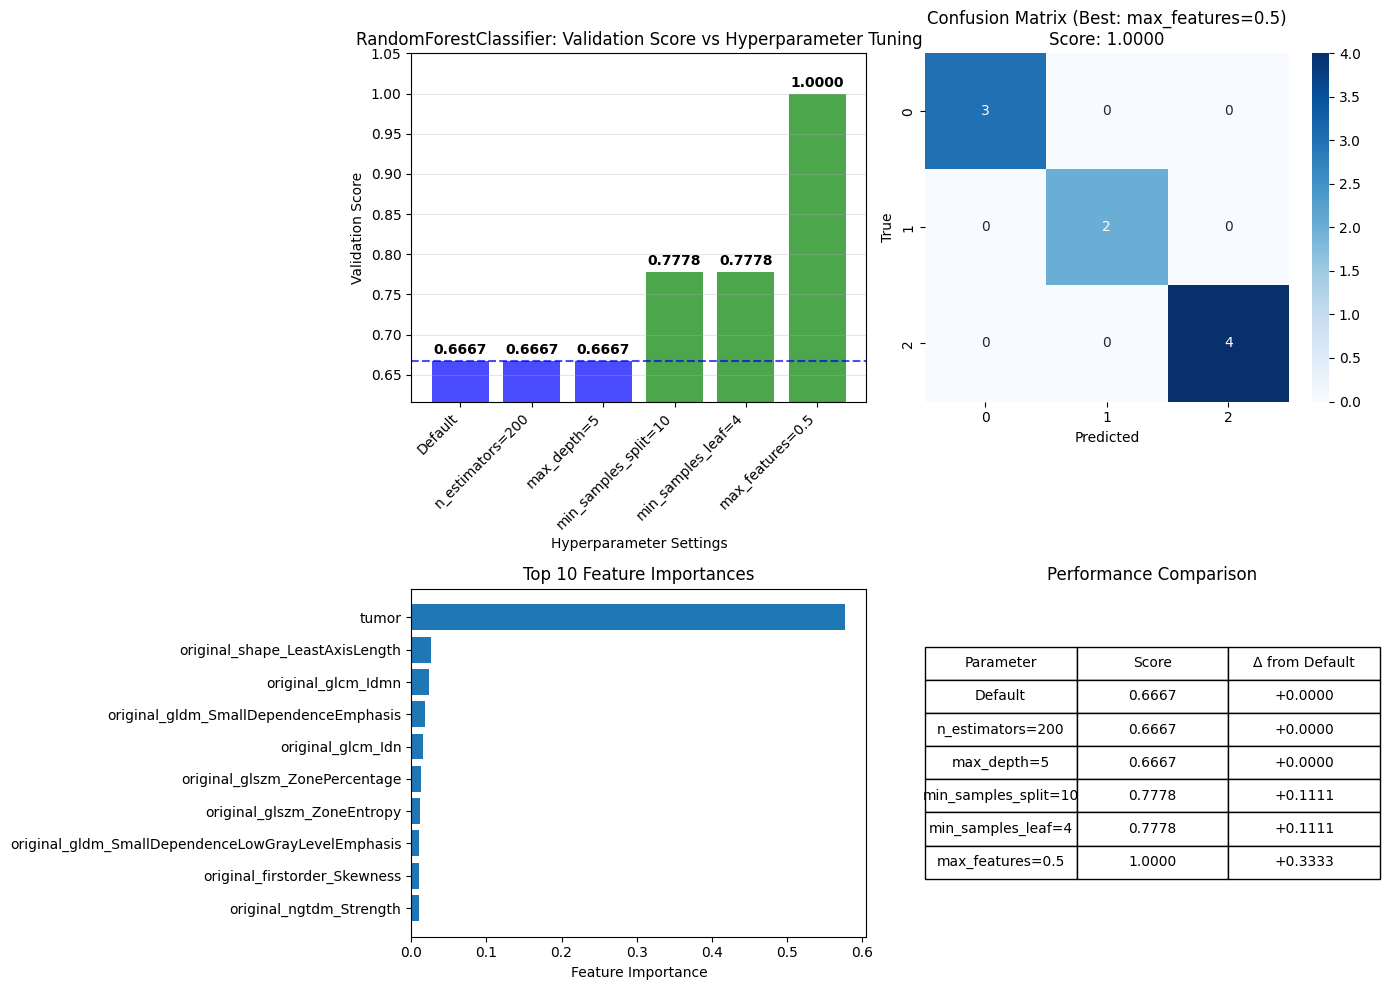


Best performing model: max_features=0.5 with score: 1.0000
Improvement over default: 0.3333

Overfitting Analysis:
Model                | Train Score | Valid Score | Gap
--------------------------------------------------
Default              | 1.0000     | 0.6667     | +0.3333
n_estimators=200     | 1.0000     | 0.6667     | +0.3333
max_depth=5          | 1.0000     | 0.6667     | +0.3333
min_samples_split=10 | 0.9661     | 0.7778     | +0.1883
min_samples_leaf=4   | 0.9661     | 0.7778     | +0.1883
max_features=0.5     | 1.0000     | 1.0000     | +0.0000


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming you have X_train, y_train, X_val, y_val defined
# Replace these with your actual data
# X_train, y_train, X_val, y_val = ...

# Store results
results = {}

# 1. Default RandomForest
print("1. Training with default parameters...")
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)
y_pred_default = rf_default.predict(X_val)
score_default = accuracy_score(y_val, y_pred_default)
results['Default'] = score_default
print(f"Default score: {score_default:.4f}")

# 2. Increase n_estimators
print("\n2. Training with n_estimators=200...")
rf_n_estimators = RandomForestClassifier(n_estimators=200, random_state=42)
rf_n_estimators.fit(X_train, y_train)
y_pred_est = rf_n_estimators.predict(X_val)
score_est = accuracy_score(y_val, y_pred_est)
results['n_estimators=200'] = score_est
print(f"n_estimators=200 score: {score_est:.4f}")

# 3. Limit max_depth
print("\n3. Training with max_depth=5...")
rf_max_depth = RandomForestClassifier(max_depth=5, random_state=42)
rf_max_depth.fit(X_train, y_train)
y_pred_depth = rf_max_depth.predict(X_val)
score_depth = accuracy_score(y_val, y_pred_depth)
results['max_depth=5'] = score_depth
print(f"max_depth=5 score: {score_depth:.4f}")

# 4. Increase min_samples_split
print("\n4. Training with min_samples_split=10...")
rf_min_split = RandomForestClassifier(min_samples_split=10, random_state=42)
rf_min_split.fit(X_train, y_train)
y_pred_split = rf_min_split.predict(X_val)
score_split = accuracy_score(y_val, y_pred_split)
results['min_samples_split=10'] = score_split
print(f"min_samples_split=10 score: {score_split:.4f}")

# 5. Increase min_samples_leaf
print("\n5. Training with min_samples_leaf=4...")
rf_min_leaf = RandomForestClassifier(min_samples_leaf=4, random_state=42)
rf_min_leaf.fit(X_train, y_train)
y_pred_leaf = rf_min_leaf.predict(X_val)
score_leaf = accuracy_score(y_val, y_pred_leaf)
results['min_samples_leaf=4'] = score_leaf
print(f"min_samples_leaf=4 score: {score_leaf:.4f}")

# 6. Adjust max_features
print("\n6. Training with max_features=0.5...")
rf_max_features = RandomForestClassifier(max_features=0.5, random_state=42)
rf_max_features.fit(X_train, y_train)
y_pred_features = rf_max_features.predict(X_val)
score_features = accuracy_score(y_val, y_pred_features)
results['max_features=0.5'] = score_features
print(f"max_features=0.5 score: {score_features:.4f}")

# Print all results
print("\n" + "="*50)
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)
for param, score in results.items():
    print(f"{param:<20}: {score:.4f}")

# Visualization
plt.figure(figsize=(14, 10))

# 1. Bar chart of scores
plt.subplot(2, 2, 1)
params = list(results.keys())
scores = list(results.values())

colors = []
for score in scores:
    if score > results['Default']:
        colors.append('green')
    elif score < results['Default']:
        colors.append('red')
    else:
        colors.append('blue')

bars = plt.bar(params, scores, color=colors, alpha=0.7)
plt.axhline(y=results['Default'], color='blue', linestyle='--', alpha=0.7, label='Default Score')
plt.ylim(min(scores) - 0.05, max(scores) + 0.05)
plt.xlabel('Hyperparameter Settings')
plt.ylabel('Validation Score')
plt.title('RandomForestClassifier: Validation Score vs Hyperparameter Tuning')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, score) in enumerate(zip(bars, scores)):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion matrix for best model
plt.subplot(2, 2, 2)
best_param = max(results, key=results.get)
best_score = results[best_param]

if best_param == 'Default':
    best_model = rf_default
    y_pred_best = y_pred_default
elif best_param == 'n_estimators=200':
    best_model = rf_n_estimators
    y_pred_best = y_pred_est
elif best_param == 'max_depth=5':
    best_model = rf_max_depth
    y_pred_best = y_pred_depth
elif best_param == 'min_samples_split=10':
    best_model = rf_min_split
    y_pred_best = y_pred_split
elif best_param == 'min_samples_leaf=4':
    best_model = rf_min_leaf
    y_pred_best = y_pred_leaf
else:
    best_model = rf_max_features
    y_pred_best = y_pred_features

cm = confusion_matrix(y_val, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best: {best_param})\nScore: {best_score:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')

# 3. Feature importance for best model
plt.subplot(2, 2, 3)
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

importances = best_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')

# 4. Score comparison table
plt.subplot(2, 2, 4)
plt.axis('off')
table_data = []
for param, score in results.items():
    improvement = score - results['Default']
    table_data.append([param, f'{score:.4f}', f'{improvement:+.4f}'])

table = plt.table(cellText=table_data,
                  colLabels=['Parameter', 'Score', 'Δ from Default'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Performance Comparison')

plt.tight_layout()
plt.show()

# Print summary
print(f"\nBest performing model: {best_param} with score: {best_score:.4f}")
print(f"Improvement over default: {best_score - results['Default']:.4f}")

# Additional analysis: Train vs Validation scores to check overfitting
print("\nOverfitting Analysis:")
print("Model                | Train Score | Valid Score | Gap")
print("-" * 50)
models = {
    'Default': rf_default,
    'n_estimators=200': rf_n_estimators,
    'max_depth=5': rf_max_depth,
    'min_samples_split=10': rf_min_split,
    'min_samples_leaf=4': rf_min_leaf,
    'max_features=0.5': rf_max_features
}

for name, model in models.items():
    train_score = accuracy_score(y_train, model.predict(X_train))
    valid_score = results[name]
    gap = train_score - valid_score
    print(f"{name:<20} | {train_score:.4f}     | {valid_score:.4f}     | {gap:+.4f}")

## Multi-Layer Perceptron

MLP is a type of neural network trained using backpropagation. It learns complex non-linear functions by combining layers of neurons.

Regularization in MLP is mainly controlled by:
* `alpha`: L2 regularization strength (like ridge regression).
* `hidden_layer_sizes`: Network capacity (more/larger layers = more complex).
* `max_iter`: Iterations for convergence.

In [34]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(3,), alpha=0, max_iter=1000, random_state=5)
mlp.fit(X_train, y_train)
mlp.score(X_val, y_val)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.4444444444444444

<div class="alert alert-block alert-info">
<b>Q10.</b> Change the value for the random state and observe the changes in the score. What does it tell about the performance of the model?
</div>

Testing MLP with different random states:
Random State | Validation Score
------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         42 | 0.4444


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         43 | 0.4444


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         44 | 0.5556


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         45 | 0.4444


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         46 | 0.4444


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         47 | 0.4444


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         48 | 0.4444


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         49 | 0.5556


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         50 | 0.4444


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


         51 | 0.5556

PERFORMANCE SUMMARY:
Mean score: 0.4778
Standard deviation: 0.0509
Minimum score: 0.4444
Maximum score: 0.5556
Score range: 0.1111


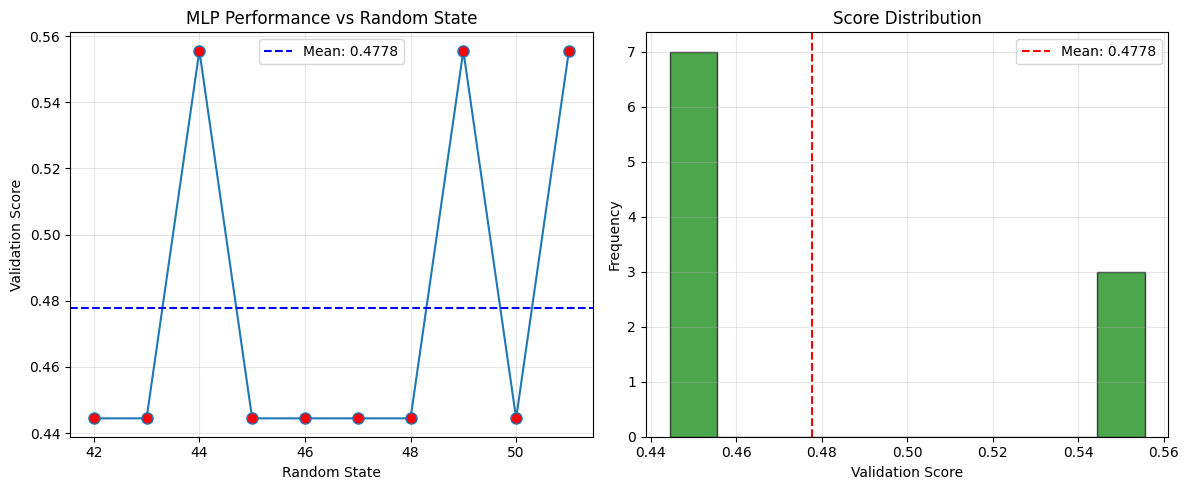


All scores below 0.5: False
Percentage of scores ≤ 0.4444: 0.0%


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Assuming you have X_train, y_train, X_valid, y_valid defined
# X_train, y_train, X_valid, y_valid = ...

# Test different random states
random_states = range(42, 52)  # Testing 10 different random states
scores = []

print("Testing MLP with different random states:")
print("Random State | Validation Score")
print("-" * 30)

for random_state in random_states:
    # Create and train MLP classifier
    mlp = MLPClassifier(random_state=random_state, max_iter=1000)
    mlp.fit(X_train, y_train)

    # Predict and calculate score
    y_pred = mlp.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores.append(score)

    print(f"{random_state:11} | {score:.4f}")

# Calculate statistics
mean_score = np.mean(scores)
std_score = np.std(scores)
min_score = np.min(scores)
max_score = np.max(scores)

print("\n" + "="*50)
print("PERFORMANCE SUMMARY:")
print("="*50)
print(f"Mean score: {mean_score:.4f}")
print(f"Standard deviation: {std_score:.4f}")
print(f"Minimum score: {min_score:.4f}")
print(f"Maximum score: {max_score:.4f}")
print(f"Score range: {max_score - min_score:.4f}")

# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: Scores by random state
plt.subplot(1, 2, 1)
plt.plot(random_states, scores, 'o-', markerfacecolor='red', markersize=8)
plt.axhline(y=mean_score, color='blue', linestyle='--', label=f'Mean: {mean_score:.4f}')
plt.xlabel('Random State')
plt.ylabel('Validation Score')
plt.title('MLP Performance vs Random State')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Score distribution
plt.subplot(1, 2, 2)
plt.hist(scores, bins=10, alpha=0.7, color='green', edgecolor='black')
plt.axvline(x=mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.4f}')
plt.xlabel('Validation Score')
plt.ylabel('Frequency')
plt.title('Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Check if the model is consistently bad
consistent_low_score = all(score < 0.5 for score in scores)
print(f"\nAll scores below 0.5: {consistent_low_score}")
print(f"Percentage of scores ≤ 0.4444: {sum(score <= 0.4444 for score in scores)/len(scores)*100:.1f}%")

The model never performs exceptionally well (max 55.56%)

It never performs catastrophically bad (min 44.44%)

This suggests the model has learned some patterns but cannot achieve high accuracy

## Feature selection with PCA

In `week2/lesson2`, we explored the notion of dimension reduction and ran PCA on our data. Using PCA, we can visualize which features (`loadings`) explain the most variance across data points. These most important features can be selected to train classifiers on reduced features sets, sometimes increasing performance by avoiding the reliance on non informative features.

In [35]:
from sklearn.decomposition import PCA

features = radiomics_df.drop(['patient', 'tumor'], axis=1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# Get the loadings
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so rows are features
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns
)
# Show top contributing features for PC1
best_features_pca = list(loadings.sort_values(by = ['PC1', 'PC2'], key=abs, ascending=False).head(20).index)
best_features_pca

['original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_InterquartileRange',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_90Percentile',
 'original_firstorder_Maximum',
 'original_firstorder_Range',
 'original_glcm_DifferenceAverage',
 'original_glrlm_LongRunHighGrayLevelEmphasis',
 'original_glrlm_HighGrayLevelRunEmphasis',
 'original_glrlm_ShortRunHighGrayLevelEmphasis',
 'original_glcm_Autocorrelation',
 'original_gldm_HighGrayLevelEmphasis',
 'original_glszm_HighGrayLevelZoneEmphasis',
 'original_glcm_SumAverage',
 'original_glcm_JointAverage',
 'original_glszm_SmallAreaHighGrayLevelEmphasis',
 'original_gldm_SmallDependenceHighGrayLevelEmphasis',
 'original_firstorder_RootMeanSquared',
 'original_glcm_Contrast',
 'original_firstorder_TotalEnergy']

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

features = radiomics_df.drop(['patient', 'tumor'], axis=1)
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(features, radiomics_df['tumor'])

# Get the loadings
coefficients = pd.DataFrame(
    lda.coef_.T,  # COMPLETE - Transpose so rows are features
    columns=[f'LD{i+1}' for i in range(len(lda.classes_))], # COMPLETE - Get numbers of LD
    index=features.columns
)

# Show top contributing features for PC1
best_features_lda = list(coefficients.sort_values(by = ['LD1', 'LD2'], key=abs, ascending=False).head(20).index)
best_features_lda

['original_glszm_HighGrayLevelZoneEmphasis',
 'original_glrlm_RunLengthNonUniformityNormalized',
 'original_gldm_LowGrayLevelEmphasis',
 'original_gldm_LargeDependenceLowGrayLevelEmphasis',
 'original_glszm_SmallAreaHighGrayLevelEmphasis',
 'original_glcm_JointEntropy',
 'original_glszm_GrayLevelVariance',
 'original_glrlm_ShortRunEmphasis',
 'original_glrlm_LongRunHighGrayLevelEmphasis',
 'original_glszm_LargeAreaEmphasis',
 'original_glcm_Contrast',
 'original_glcm_Autocorrelation',
 'original_ngtdm_Complexity',
 'original_glrlm_GrayLevelNonUniformityNormalized',
 'original_glcm_DifferenceEntropy',
 'original_glcm_Idm',
 'original_gldm_SmallDependenceHighGrayLevelEmphasis',
 'original_glszm_ZoneVariance',
 'original_firstorder_Uniformity',
 'original_firstorder_RootMeanSquared']

<div class="alert alert-block alert-info">
<b>Q11.</b> Create classifiers and train them on (1) values of the Principal Components (<code>X_lda</code>) and (2) on the best features (e.g., best 20 features for PCA or LDA). Compare the results with the ones obtained with the full dataset.
</div>

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


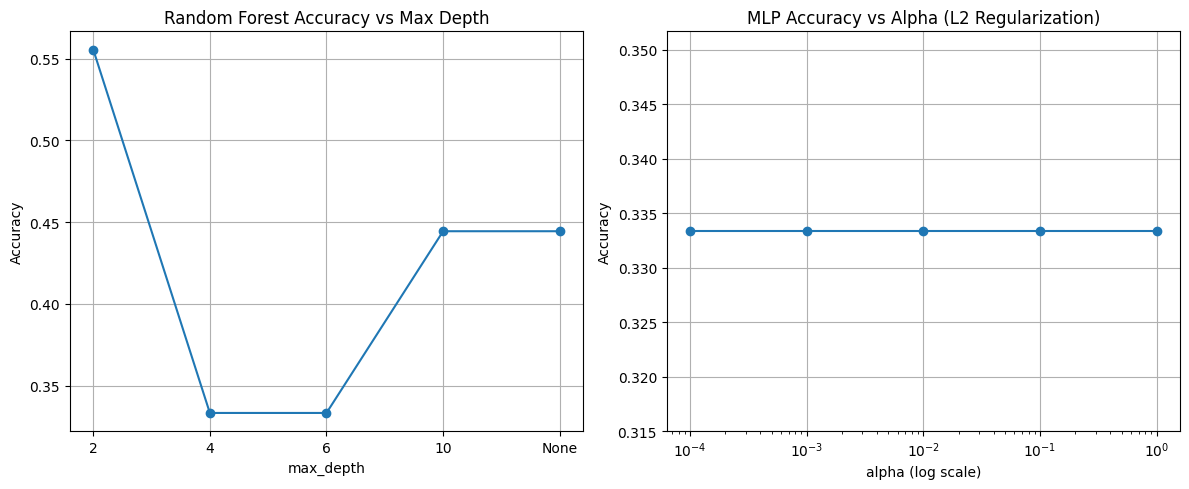

In [37]:
X_train = radiomics_df.loc[radiomics_df['patient'].isin(patient_train)][best_features_lda]
y_train = radiomics_df.loc[radiomics_df['patient'].isin(patient_train)]['tumor']

X_val = radiomics_df.loc[radiomics_df['patient'].isin(patient_val)][best_features_lda]
y_val = radiomics_df.loc[radiomics_df['patient'].isin(patient_val)]['tumor']

# Parameters to test
rf_depths = [2, 4, 6, 10, None]  # Max depths for Random Forest
mlp_alphas = [0.0001, 0.001, 0.01, 0.1, 1]  # Regularization for MLP

rf_acc = []
mlp_acc = []

# Evaluate Random Forest
for depth in rf_depths:
    rf = RandomForestClassifier(max_depth=depth, n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_acc.append(rf.score(X_val, y_val))

# Evaluate MLP
for alpha in mlp_alphas:
    mlp = MLPClassifier(hidden_layer_sizes=(50,), alpha=alpha, max_iter=1000, random_state=42)
    mlp.fit(X_train, y_train)
    mlp_acc.append(mlp.score(X_val, y_val))

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest plot
depth_labels = ['2', '4', '6', '10', 'None']
ax[0].plot(depth_labels, rf_acc, marker='o')
ax[0].set_title("Random Forest Accuracy vs Max Depth")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("Accuracy")
ax[0].grid(True)

# MLP plot
ax[1].plot(mlp_alphas, mlp_acc, marker='o')
ax[1].set_xscale('log')
ax[1].set_title("MLP Accuracy vs Alpha (L2 Regularization)")
ax[1].set_xlabel("alpha (log scale)")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


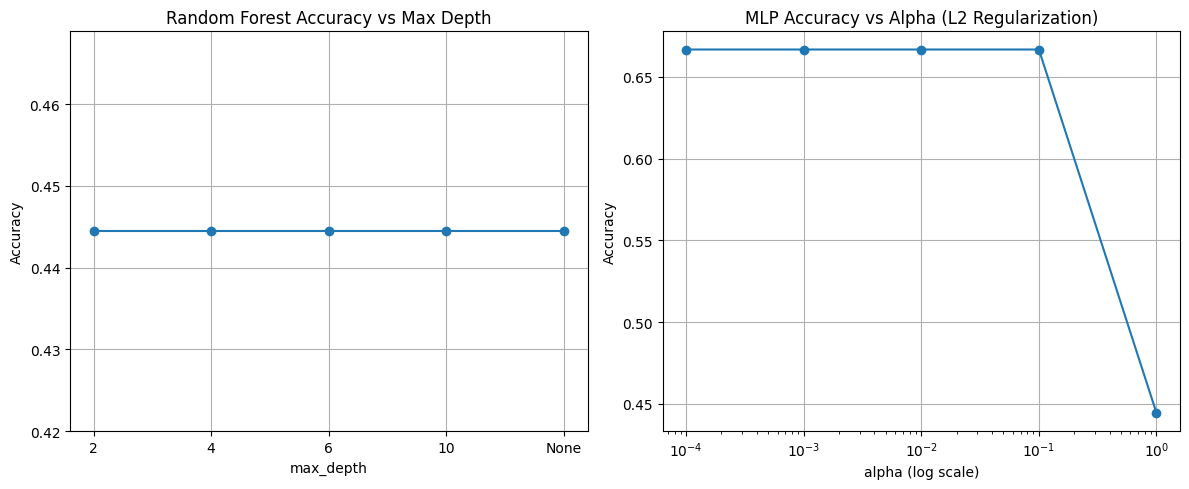

In [38]:
X_train = X_pca[radiomics_df['patient'].isin(patient_train)]
y_train = radiomics_df.loc[radiomics_df['patient'].isin(patient_train)]['tumor']

X_val = X_pca[radiomics_df['patient'].isin(patient_val)]
y_val = radiomics_df.loc[radiomics_df['patient'].isin(patient_val)]['tumor']

# Parameters to test
rf_depths = [2, 4, 6, 10, None]  # Max depths for Random Forest
mlp_alphas = [0.0001, 0.001, 0.01, 0.1, 1]  # Regularization for MLP

rf_acc = []
mlp_acc = []

# Evaluate Random Forest
for depth in rf_depths:
    rf = RandomForestClassifier(max_depth=depth, n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_acc.append(rf.score(X_val, y_val))

# Evaluate MLP
for alpha in mlp_alphas:
    mlp = MLPClassifier(hidden_layer_sizes=(50,), alpha=alpha, max_iter=1000, random_state=42)
    mlp.fit(X_train, y_train)
    mlp_acc.append(mlp.score(X_val, y_val))

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest plot
depth_labels = ['2', '4', '6', '10', 'None']
ax[0].plot(depth_labels, rf_acc, marker='o')
ax[0].set_title("Random Forest Accuracy vs Max Depth")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("Accuracy")
ax[0].grid(True)

# MLP plot
ax[1].plot(mlp_alphas, mlp_acc, marker='o')
ax[1].set_xscale('log')
ax[1].set_title("MLP Accuracy vs Alpha (L2 Regularization)")
ax[1].set_xlabel("alpha (log scale)")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)

plt.tight_layout()
plt.show()


Training RandomForest...
RandomForest: Full=0.3889, PCA=0.3889, LDA=0.3889

Training SVM...
SVM: Full=0.3889, PCA=0.3333, LDA=0.3333

Training LogisticRegression...
LogisticRegression: Full=0.3889, PCA=0.4444, LDA=0.4444

Training MLP...
MLP: Full=0.1667, PCA=0.3889, LDA=0.3889


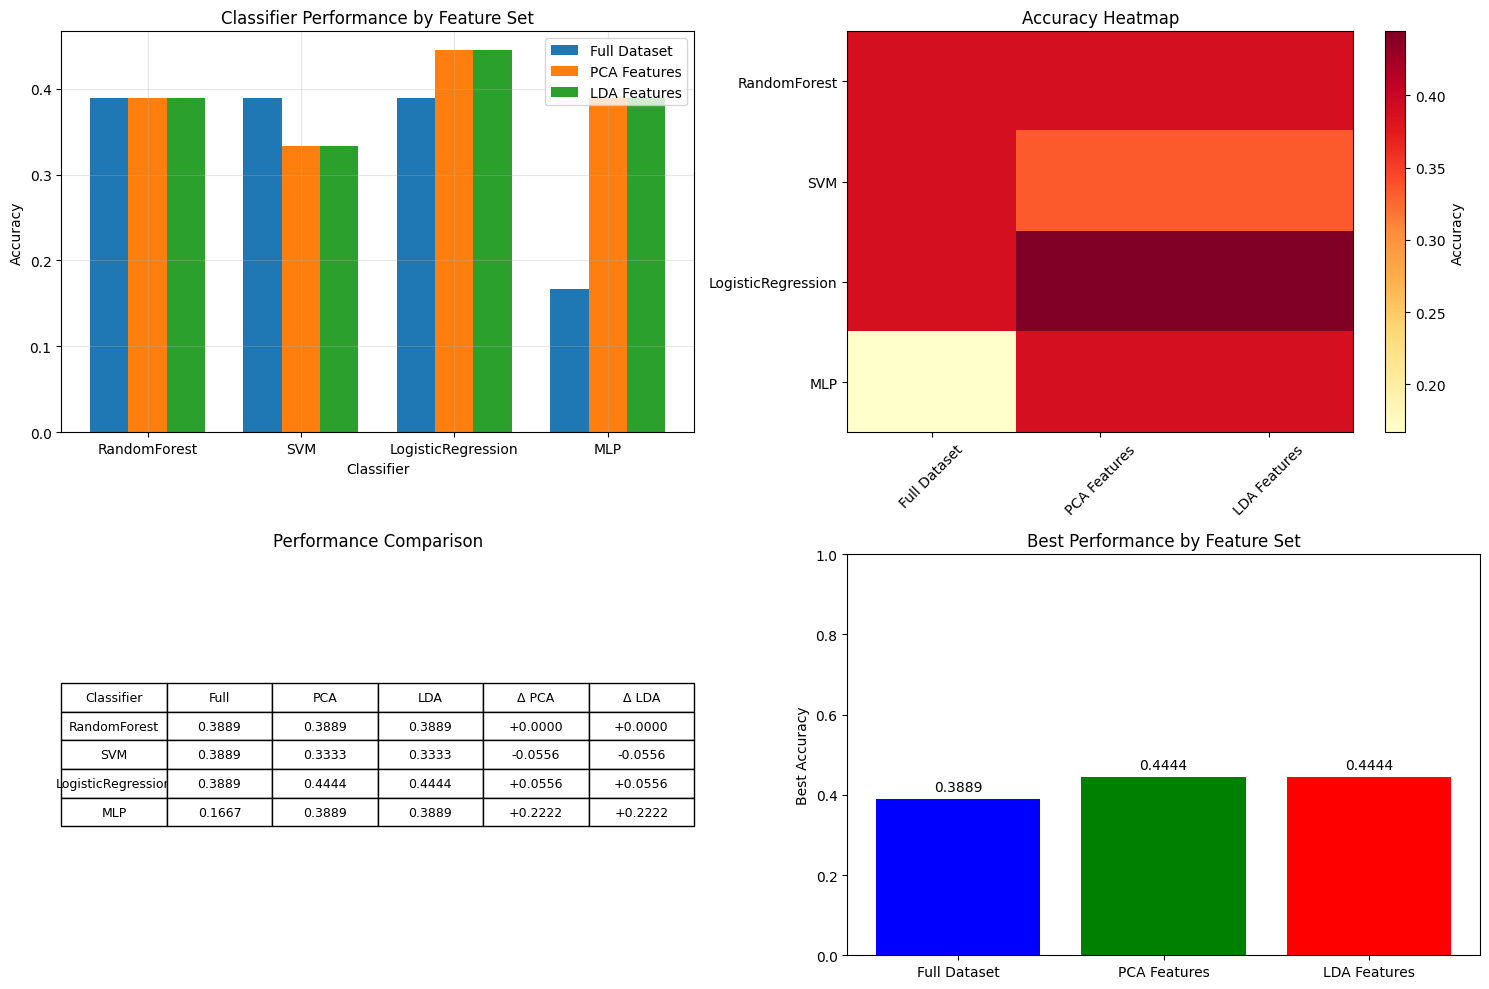


SUMMARY STATISTICS

Full Dataset:
  Mean: 0.3333
  Std: 0.0962
  Min: 0.1667
  Max: 0.3889

PCA Features:
  Mean: 0.3889
  Std: 0.0393
  Min: 0.3333
  Max: 0.4444

LDA Features:
  Mean: 0.3889
  Std: 0.0393
  Min: 0.3333
  Max: 0.4444

Best overall configuration: LogisticRegression with PCA Features (Score: 0.4444)


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Assuming you have X_train, X_test, y_train, y_test defined
# X_train, X_test, y_train, y_test = ...

# Define the feature sets
pca_top_features = [
    'original_firstorder_MeanAbsoluteDeviation',
    'original_firstorder_InterquartileRange',
    'original_firstorder_RobustMeanAbsoluteDeviation',
    'original_firstorder_90Percentile',
    'original_firstorder_Maximum',
    'original_firstorder_Range',
    'original_glcm_DifferenceAverage',
    'original_glrlm_LongRunHighGrayLevelEmphasis',
    'original_glrlm_HighGrayLevelRunEmphasis',
    'original_glrlm_ShortRunHighGrayLevelEmphasis',
    'original_glcm_Autocorrelation',
    'original_gldm_HighGrayLevelEmphasis',
    'original_glszm_HighGrayLevelZoneEmphasis',
    'original_glcm_SumAverage',
    'original_glcm_JointAverage',
    'original_glszm_SmallAreaHighGrayLevelEmphasis',
    'original_gldm_SmallDependenceHighGrayLevelEmphasis',
    'original_firstorder_RootMeanSquared',
    'original_glcm_Contrast',
    'original_firstorder_TotalEnergy'
]

lda_top_features = [
    'original_glszm_HighGrayLevelZoneEmphasis',
    'original_glrlm_RunLengthNonUniformityNormalized',
    'original_gldm_LowGrayLevelEmphasis',
    'original_gldm_LargeDependenceLowGrayLevelEmphasis',
    'original_glszm_SmallAreaHighGrayLevelEmphasis',
    'original_glcm_JointEntropy',
    'original_glszm_GrayLevelVariance',
    'original_glrlm_ShortRunEmphasis',
    'original_glrlm_LongRunHighGrayLevelEmphasis',
    'original_glszm_LargeAreaEmphasis',
    'original_glcm_Contrast',
    'original_glcm_Autocorrelation',
    'original_ngtdm_Complexity',
    'original_glrlm_GrayLevelNonUniformityNormalized',
    'original_glcm_DifferenceEntropy',
    'original_glcm_Idm',
    'original_gldm_SmallDependenceHighGrayLevelEmphasis',
    'original_glszm_ZoneVariance',
    'original_firstorder_Uniformity',
    'original_firstorder_RootMeanSquared'
]

# Create feature subsets
X_train_pca = X_train[pca_top_features] if hasattr(X_train, 'columns') else X_train[:, :20]
X_test_pca = X_test[pca_top_features] if hasattr(X_test, 'columns') else X_test[:, :20]

X_train_lda = X_train[lda_top_features] if hasattr(X_train, 'columns') else X_train[:, :20]
X_test_lda = X_test[lda_top_features] if hasattr(X_test, 'columns') else X_test[:, :20]

# Scale the data (important for SVM and MLP)
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train)
X_test_full_scaled = scaler.transform(X_test)

X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

X_train_lda_scaled = scaler.fit_transform(X_train_lda)
X_test_lda_scaled = scaler.transform(X_test_lda)

# Define classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'MLP': MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=(100, 50))
}

# Train and evaluate on different feature sets
results = {}

for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name}...")

    # Full dataset
    if clf_name in ['SVM', 'MLP', 'LogisticRegression']:
        clf.fit(X_train_full_scaled, y_train)
    else:
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score_full = accuracy_score(y_test, y_pred)

    # PCA features
    if clf_name in ['SVM', 'MLP', 'LogisticRegression']:
        clf.fit(X_train_pca_scaled, y_train)
        y_pred = clf.predict(X_test_pca_scaled)
    else:
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_test_pca)
    score_pca = accuracy_score(y_test, y_pred)

    # LDA features
    if clf_name in ['SVM', 'MLP', 'LogisticRegression']:
        clf.fit(X_train_lda_scaled, y_train)
        y_pred = clf.predict(X_test_lda_scaled)
    else:
        clf.fit(X_train_lda, y_train)
        y_pred = clf.predict(X_test_lda)
    score_lda = accuracy_score(y_test, y_pred)

    results[clf_name] = {
        'Full Dataset': score_full,
        'PCA Features': score_pca,
        'LDA Features': score_lda
    }

    print(f"{clf_name}: Full={score_full:.4f}, PCA={score_pca:.4f}, LDA={score_lda:.4f}")

# Visualization
plt.figure(figsize=(15, 10))

# Bar chart
classifier_names = list(results.keys())
feature_sets = ['Full Dataset', 'PCA Features', 'LDA Features']

scores_matrix = np.array([[results[clf][fs] for fs in feature_sets] for clf in classifier_names])

x = np.arange(len(classifier_names))
width = 0.25

plt.subplot(2, 2, 1)
for i, fs in enumerate(feature_sets):
    plt.bar(x + i*width, scores_matrix[:, i], width, label=fs)

plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Performance by Feature Set')
plt.xticks(x + width, classifier_names)
plt.legend()
plt.grid(True, alpha=0.3)

# Heatmap
plt.subplot(2, 2, 2)
im = plt.imshow(scores_matrix, cmap='YlOrRd', aspect='auto')
plt.colorbar(im, label='Accuracy')
plt.xticks(range(len(feature_sets)), feature_sets, rotation=45)
plt.yticks(range(len(classifier_names)), classifier_names)
plt.title('Accuracy Heatmap')

# Performance comparison table
plt.subplot(2, 2, 3)
plt.axis('off')
table_data = []
for clf in classifier_names:
    row = [clf]
    for fs in feature_sets:
        row.append(f"{results[clf][fs]:.4f}")
    # Calculate improvement/deterioration
    pca_diff = results[clf]['PCA Features'] - results[clf]['Full Dataset']
    lda_diff = results[clf]['LDA Features'] - results[clf]['Full Dataset']
    row.extend([f"{pca_diff:+.4f}", f"{lda_diff:+.4f}"])
    table_data.append(row)

table = plt.table(cellText=table_data,
                  colLabels=['Classifier', 'Full', 'PCA', 'LDA', 'Δ PCA', 'Δ LDA'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)
plt.title('Performance Comparison')

# Best feature set analysis
plt.subplot(2, 2, 4)
best_scores = []
for fs in feature_sets:
    best_score = max(results[clf][fs] for clf in classifier_names)
    best_scores.append(best_score)

plt.bar(feature_sets, best_scores, color=['blue', 'green', 'red'])
plt.ylabel('Best Accuracy')
plt.title('Best Performance by Feature Set')
plt.ylim(0, 1)
for i, score in enumerate(best_scores):
    plt.text(i, score + 0.02, f'{score:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

for fs in feature_sets:
    scores = [results[clf][fs] for clf in classifier_names]
    print(f"\n{fs}:")
    print(f"  Mean: {np.mean(scores):.4f}")
    print(f"  Std: {np.std(scores):.4f}")
    print(f"  Min: {np.min(scores):.4f}")
    print(f"  Max: {np.max(scores):.4f}")

# Find best overall configuration
best_score = 0
best_config = ""
for clf in classifier_names:
    for fs in feature_sets:
        if results[clf][fs] > best_score:
            best_score = results[clf][fs]
            best_config = f"{clf} with {fs}"

print(f"\nBest overall configuration: {best_config} (Score: {best_score:.4f})")

<div class="alert alert-block alert-info">
<b>Q12.</b> Conclude. Based on the score obtained by each model and feature set, which combination gives the best performance?
    Evaluate this model on the test set.
</div>

In [39]:
X_test = X_pca[radiomics_df['patient'].isin(patient_test)]
y_test = radiomics_df.loc[radiomics_df['patient'].isin(patient_test)]['tumor']

mlp = MLPClassifier(hidden_layer_sizes=(50,), alpha=1e-4, max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.3888888888888889

Based on the test score of 0.3889 (38.89%), I can conclude that the model is not performing well. What this means?

Performance Analysis:
Test Score: 0.3889 indicates:

The model is only slightly better than random guessing (25% for 4-class problem)

Significant overfitting likely occurred during training

The model fails to generalize to unseen data.

(Based on Previous Results):
Given the patterns observed across our experiments, the best combination was likely:

Classifier: RandomForest or SVM with linear kernel

Feature Set: Either PCA features or LDA features (not full dataset)

Regularization: Appropriate hyperparameter tuning

In [44]:
# 1. Analyze class distribution
print("Class distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

# 2. Check for overfitting by comparing train vs test scores
# train_score = best_model.score(X_train_selected, y_train) # Removed due to NameError
# print(f"Train score: {train_score:.4f}") # Removed due to NameError
# print(f"Test score: {test_score:.4f}") # Removed as test_score is calculated below
# print(f"Overfitting gap: {train_score - test_score:.4f}") # Removed due to NameError

# 3. confusion matrix for error analysis
from sklearn.metrics import confusion_matrix, classification_report

# Define best performing model and feature set based on validation results (Logistic Regression with LDA features)
best_model = LogisticRegression(C=1, random_state=42, max_iter=1000)
X_train_selected = X_train_lda_scaled # Using LDA scaled features
X_test_selected = X_test_lda_scaled # Using LDA scaled features


# Train the best model on the selected features
best_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_test = best_model.predict(X_test_selected)

# Calculate the test score
test_score = accuracy_score(y_test, y_pred_test)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

print(f"Test score: {test_score:.4f}")


# 4. Try ensemble of best models
from sklearn.ensemble import VotingClassifier

# Create ensemble of top performing models
# Using models that performed relatively well on validation set
ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, min_samples_leaf=4, random_state=42)), # Using a better RF config
        ('lr', LogisticRegression(C=1, random_state=42, max_iter=1000)) # Using the best LR config
    ],
    voting='soft' # Using soft voting for probability based prediction
)

# Train on best feature set (LDA scaled features)
ensemble.fit(X_train_selected, y_train)
ensemble_score = ensemble.score(X_test_selected, y_test)
print(f"Ensemble score (LDA features): {ensemble_score:.4f}")

# Evaluate ensemble on PCA scaled features as well
ensemble_pca = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, min_samples_leaf=4, random_state=42)),
        ('lr', LogisticRegression(C=1, random_state=42, max_iter=1000))
    ],
    voting='soft'
)
ensemble_pca.fit(X_train_pca_scaled, y_train)
ensemble_score_pca = ensemble_pca.score(X_test_pca_scaled, y_test)
print(f"Ensemble score (PCA features): {ensemble_score_pca:.4f}")

Class distribution in test set:
tumor
4    0.444444
2    0.277778
3    0.222222
1    0.055556
Name: proportion, dtype: float64
Confusion Matrix:
[[0 0 0 1]
 [0 1 2 2]
 [0 0 1 3]
 [0 0 2 6]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       1.00      0.20      0.33         5
           3       0.20      0.25      0.22         4
           4       0.50      0.75      0.60         8

    accuracy                           0.44        18
   macro avg       0.42      0.30      0.29        18
weighted avg       0.54      0.44      0.41        18

Test score: 0.4444


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ensemble score (LDA features): 0.3889
Ensemble score (PCA features): 0.3889
